In [1]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# # Algorithms
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# from sklearn.decomposition import PCA
# from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from statsmodels.tsa.arima_model import ARIMA
# import pmdarima as pm
from sklearn.model_selection import ParameterGrid
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sales_s = pd.read_pickle("sales_s.pkl")
sales_s.head()

,P_6,P_22,P_24,P_30,P_37,P_38,P_47,P_55,P_64
2014-07-31,2244,10467,7204,19852,1865,3510,510,3849,1039
2014-08-31,1970,11319,7477,19164,2043,3804,524,3980,1134
2014-09-30,1877,10956,7592,17382,2188,3859,595,3787,1160
2014-10-31,1615,9822,7435,16034,2297,3823,636,3745,1180
2014-11-30,1796,10427,7434,16430,2432,3535,572,3861,1065


Pour la démonstration de la demarche suivie dans l'apprentissage supervisé, on a selectionné aléatoirement un produit (P_64).


In [4]:
sales_s_p64 = sales_s[['P_64']]
sales_s_p64

,P_64
2014-07-31,1039
2014-08-31,1134
2014-09-30,1160
2014-10-31,1180
2014-11-30,1065
...,...
2019-05-31,1634
2019-06-30,1597
2019-07-31,1560
2019-08-31,1817



On a commencé par implémenter le concept de "feature engineering" ou on a généré les variables nécessaires pour entrainer les modèles d'apprentissage.

- Variables de temps : année, mois, trimestre
- Valeurs retardées des séries temporelles
- Statistiques : la moyenne et l'écart type des valeurs retardées. 

titre : Visualisation des variables cycliques 

Les variables temporelles tels que le mois et le trimestre sont cycliques. Par exemple, le mois oscille entre 1 et 12 pour chaque année. Alors que la différence entre chaque mois augmente de 1 au cours de l'année, entre deux ans, la caractéristique du mois passe de 12 (décembre) à 1 (janvier). Il en résulte une différence de -11, ce qui peut dérouter beaucoup de modèles.


Pour résoudre ce problème, on a effectué une transformation par la fonction cosinus après avoir normalisé les variables entre 0 et 2π, ce qui correspond à un cycle de cosinus, cette solution ne régle pas le problème complétement car deux valeurs différentes peuvent avoir la même image par la fonction cosinus. La meilleure façon de résoudre ce nouveau problème était d'ajouter une autre information cyclique pour distinguer deux temps avec des valeurs de cosinus identiques, il s'agit de la fonction sinus. Nous pourrions le considérer comme un système de coordonnées à deux axes.

In [5]:
sales_s_p64['year'] = sales_s_p64.index.year
sales_s_p64['month'] = sales_s_p64.index.month
sales_s_p64['quarter'] = sales_s_p64.index.quarter
sales_s_p64

,P_64,year,month,quarter
2014-07-31,1039,2014,7,3
2014-08-31,1134,2014,8,3
2014-09-30,1160,2014,9,3
2014-10-31,1180,2014,10,4
2014-11-30,1065,2014,11,4
...,...,...,...,...
2019-05-31,1634,2019,5,2
2019-06-30,1597,2019,6,2
2019-07-31,1560,2019,7,3
2019-08-31,1817,2019,8,3


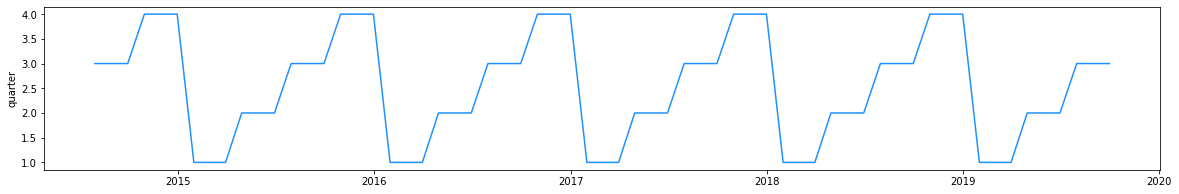

In [6]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=sales_s_p64.index, y=sales_s_p64['quarter'], color='dodgerblue')
# ax.set_xlim([date(2014, 7, 31), date(2019, 9, 30)])
plt.show()

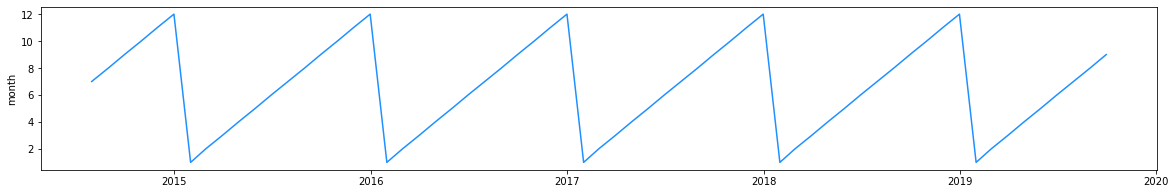

In [7]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=sales_s_p64.index, y=sales_s_p64['month'], color='dodgerblue')
# ax.set_xlim([date(2014, 7, 31), date(2019, 9, 30)])
plt.show()

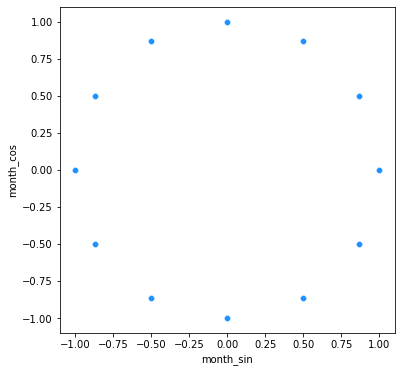

In [8]:
month_in_year = 12
sales_s_p64['month_sin'] = np.sin(2*np.pi*sales_s_p64['month']/month_in_year)
sales_s_p64['month_cos'] = np.cos(2*np.pi*sales_s_p64['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=sales_s_p64.month_sin, y=sales_s_p64.month_cos, color='dodgerblue')
plt.show()

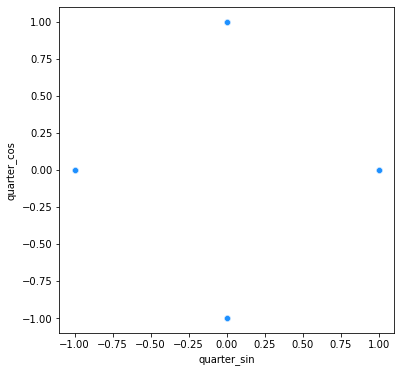

In [9]:
month_quarter =4
sales_s_p64['quarter_sin'] = np.sin(2*np.pi*sales_s_p64['quarter']/month_quarter)
sales_s_p64['quarter_cos'] = np.cos(2*np.pi*sales_s_p64['quarter']/month_quarter)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=sales_s_p64.quarter_sin, y=sales_s_p64.quarter_cos, color='dodgerblue')
plt.show()

In [10]:
sales_s_p64

,P_64,year,month,quarter,month_sin,month_cos,quarter_sin,quarter_cos
2014-07-31,1039,2014,7,3,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16
2014-08-31,1134,2014,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16
2014-09-30,1160,2014,9,3,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16
2014-10-31,1180,2014,10,4,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00
2014-11-30,1065,2014,11,4,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00
...,...,...,...,...,...,...,...,...
2019-05-31,1634,2019,5,2,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00
2019-06-30,1597,2019,6,2,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
2019-07-31,1560,2019,7,3,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16
2019-08-31,1817,2019,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16


Comme indiqué précédemment, on a utilisé les variables de la série décalées pour beneficier de l'autocorrélation existante dans la série. Pour prendre en compte l'effet de la saisonnalité, on a considéré 12 retards.

In [11]:
for i in range(1, 13):
    sales_s_p64[f"lag{i}"] = sales_s_p64.P_64.shift(i)

In [12]:
# data = sales_s_p64.loc[:, ~sales_s_p64.columns.isin(['month', 'quarter', 'lag3', 'lag4'])]
sales_s_p64

,P_64,year,month,quarter,month_sin,month_cos,quarter_sin,quarter_cos,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
2014-07-31,1039,2014,7,3,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,1134,2014,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,1160,2014,9,3,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,1134.0,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-31,1180,2014,10,4,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,1160.0,1134.0,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30,1065,2014,11,4,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,1180.0,1160.0,1134.0,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31,1634,2019,5,2,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0,1506.0,1649.0
2019-06-30,1597,2019,6,2,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00,1634.0,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0,1506.0
2019-07-31,1560,2019,7,3,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16,1597.0,1634.0,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0
2019-08-31,1817,2019,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,1560.0,1597.0,1634.0,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0


In [13]:
df = sales_s_p64.copy()

In [14]:
df["Date"] = sales_s[['P_64']].index

In [15]:
df

,P_64,year,month,quarter,month_sin,month_cos,quarter_sin,quarter_cos,lag1,lag2,...,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,Date
2014-07-31,1039,2014,7,3,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-07-31
2014-08-31,1134,2014,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,1039.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-08-31
2014-09-30,1160,2014,9,3,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,1134.0,1039.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-09-30
2014-10-31,1180,2014,10,4,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,1160.0,1134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-10-31
2014-11-30,1065,2014,11,4,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,1180.0,1160.0,...,1039.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31,1634,2019,5,2,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00,1498.0,1577.0,...,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0,1506.0,1649.0,2019-05-31
2019-06-30,1597,2019,6,2,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00,1634.0,1498.0,...,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0,1506.0,2019-06-30
2019-07-31,1560,2019,7,3,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16,1597.0,1634.0,...,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,1429.0,2019-07-31
2019-08-31,1817,2019,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16,1560.0,1597.0,...,1498.0,1577.0,1528.0,1717.0,1747.0,1749.0,1783.0,1703.0,1651.0,2019-08-31


On a généré les moyennes mobiles et ecart-types mobiles (trimestrielle, semestrielle et annuelle) des valeurs décalées afin de détecter la tendance globale des données.

In [16]:
df.reset_index(drop=True, inplace=True)
lag_features = ["P_64"]
window1 = 3
window2 = 6
window3 = 12

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

,P_64,year,month,quarter,month_sin,month_cos,quarter_sin,quarter_cos,lag1,lag2,...,lag10,lag11,lag12,Date,P_64_mean_lag3,P_64_mean_lag6,P_64_mean_lag12,P_64_std_lag3,P_64_std_lag6,P_64_std_lag12
Date,,,,,,,,,,,,,,,,,,,,,
2014-07-31,1039,2014,7,3,-0.500000,-8.660254e-01,-1.000000e+00,-1.836970e-16,1406.209677,1399.47541,...,1368.113208,1360.788462,1352.509804,2014-07-31,1395.29834,1382.994995,1358.878906,60.828255,81.603775,99.325943
2014-08-31,1134,2014,8,3,-0.866025,-5.000000e-01,-1.000000e+00,-1.836970e-16,1039.000000,1399.47541,...,1368.113208,1360.788462,1352.509804,2014-08-31,1039.00000,1039.000000,1039.000000,60.828255,81.603775,99.325943
2014-09-30,1160,2014,9,3,-1.000000,-1.836970e-16,-1.000000e+00,-1.836970e-16,1134.000000,1039.00000,...,1368.113208,1360.788462,1352.509804,2014-09-30,1086.50000,1086.500000,1086.500000,67.175148,67.175148,67.175148
2014-10-31,1180,2014,10,4,-0.866025,5.000000e-01,-2.449294e-16,1.000000e+00,1160.000000,1134.00000,...,1368.113208,1360.788462,1352.509804,2014-10-31,1111.00000,1111.000000,1111.000000,63.694584,63.694584,63.694584
2014-11-30,1065,2014,11,4,-0.500000,8.660254e-01,-2.449294e-16,1.000000e+00,1180.000000,1160.00000,...,1368.113208,1360.788462,1352.509804,2014-11-30,1158.00000,1128.250000,1128.250000,23.065125,62.409267,62.409267


Pour la validation des modèles on a divisé le jeu de données en deux parties : la premiere partie pour l'entrainement du modèle (train set) et le reste (la derniere année) est reservé pour l'évaluation.

On a ajusté un modèle de regression linéaire multiple sur l'ensemble des variables et on a obtenu une erreur (MAPE) de 5.29% sur le test set.

In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [20]:
y = df.dropna().P_64
X = df.dropna().drop(['P_64', 'Date'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.15)

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
def plotModelResults(models, X_train, X_test, y_train, y_test,\
                     plot_intervals=False, plot_anomalies=False, axe = False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
        models = [["ridge": mod_r], ["lasso": mod_l]]
        models = ["ridge": mod_r]
    """
    
    errors = [0]*len(models)
    predictions = [0]*len(models)
    for i, model in enumerate(models) :
        predictions[i] = model[1].predict(X_test)
        errors[i] = mean_absolute_percentage_error(predictions[i], y_test)
        
    
    min_index = errors.index(min(errors))
    error = errors[min_index]
    prediction = predictions[min_index]
    winner = models[min_index][0]
    model = models[min_index][1]
    
    index_of_pred = y_test.index
    pred_series = pd.Series(prediction, index=index_of_pred)
    
    if not axe : 
        axe = plt
        axe.figure(figsize=(15, 7))
    axe.plot(pred_series, "g", label="prediction", linewidth=2.0)
    axe.plot(pd.concat([y_train, y_test]), label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = pred_series - (mae + scale * deviation)
        upper = pred_series + (mae + scale * deviation)
        
        axe.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        axe.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            anomalies_series = pd.Series(anomalies, index=index_of_pred)
            if ~np.isnan(anomalies).all() : axe.plot(anomalies_series, "o", markersize=10, label = "Anomalies")
    
#     error = mean_absolute_percentage_error(prediction, y_test)
    f = axe.title if axe == plt else axe.set_title
    f(f"{y_test.name},  model : {winner},  Mean absolute percentage error {error:.2f}%")
    axe.axvspan(index_of_pred[0], index_of_pred[-1],  color=sns.xkcd_rgb['grey'], alpha=0.2)
    axe.legend(loc="best")
#     plt.tight_layout()
#     plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

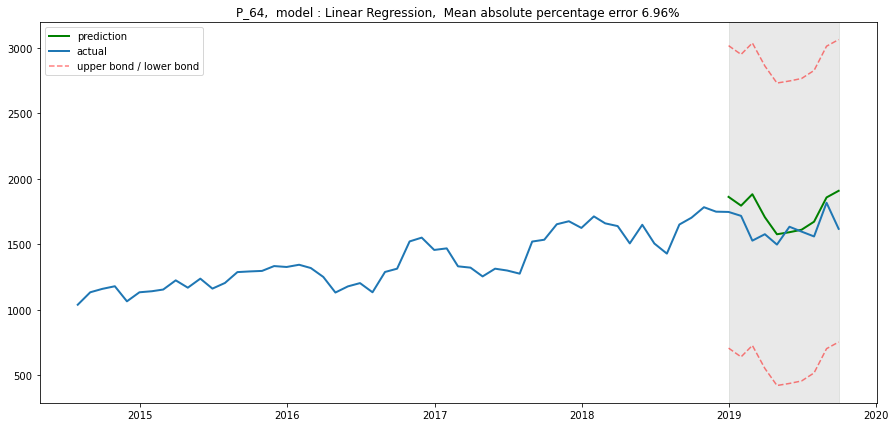

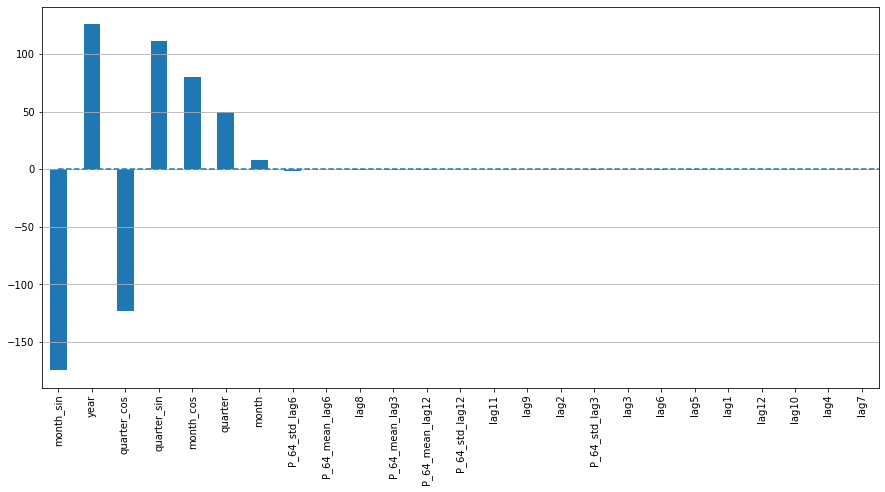

In [23]:
plotModelResults([["Linear Regression", lr]], X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, \
                 plot_intervals=True)
plotCoefficients(lr)

Ce premier modèle présente des défauts

La régression linéaire a donné des résultats assez biens. Cependant ce modèle simple présente des défauts,certaines variables explicatives sont fortement corrélées et toutes les variables ne sont pas également saines,certaines peuvent entraîner un surapprentissage tandis que d'autres doivent être supprimées.
D'autre part, puisque on a différentes échelles dans les variables, celles ci doivent etre transformées en une même échelle pour explorer l'importance des caractéristiques et, plus tard, la régularisation.


In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [25]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

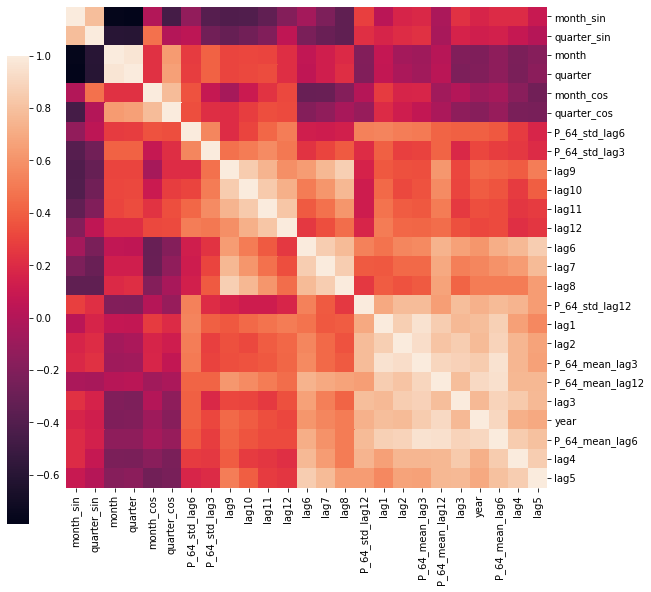

In [26]:
temp = pd.DataFrame(X_train_scaled)
temp.columns = X_train.columns
# plt.figure(figsize=(10, 8))
# sns.heatmap(df.corr());
cg = sns.clustermap(temp.corr(), figsize=(10, 10), cbar_pos=(.1, .1, .03, .65))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
plt.show()

Pour une meilleure optimisation des variables explicatives, on a  appliqué la régularisation. Deux des modèles de régression avec régularisation les plus populaires sont les régressions Ridge et Lasso. Ils ajoutent tous deux des contraintes supplémentaires à notre fonction de perte.

Dans le cas de la régression Ridge, ces contraintes sont la somme des carrés des coefficients multipliée par le coefficient de régularisation. Plus le coefficient d'une caractéristique est grand, plus notre perte sera importante. Par conséquent, nous essaierons d'optimiser le modèle tout en gardant les coefficients assez bas.

À la suite de cette régularisation L2, nous aurons un biais plus élevé et une variance plus faible, donc le modèle se généralisera mieux.

Le deuxième modèle de régression, la régression Lasso, ajoute à la fonction de perte, non pas des carrés, mais des valeurs absolues des coefficients. Par conséquent, au cours du processus d'optimisation, les coefficients des caractéristiques sans importance peuvent devenir des zéros, ce qui permet une sélection automatisée des caractéristiques. Ce type de régularisation est appelé L1.


In [27]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

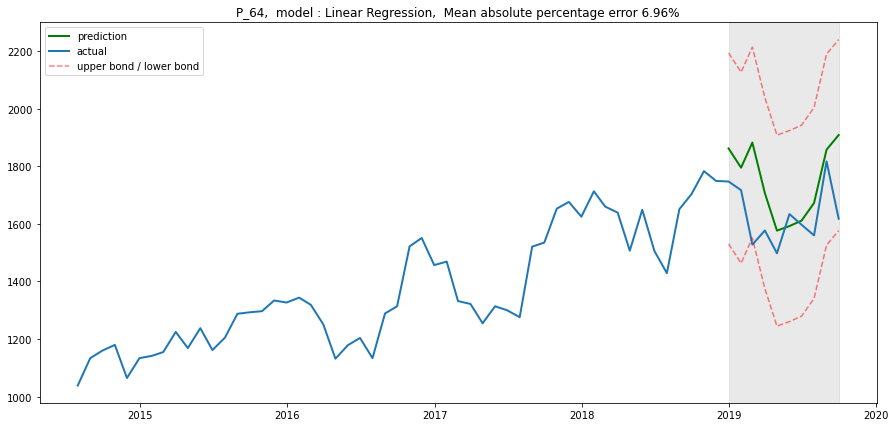

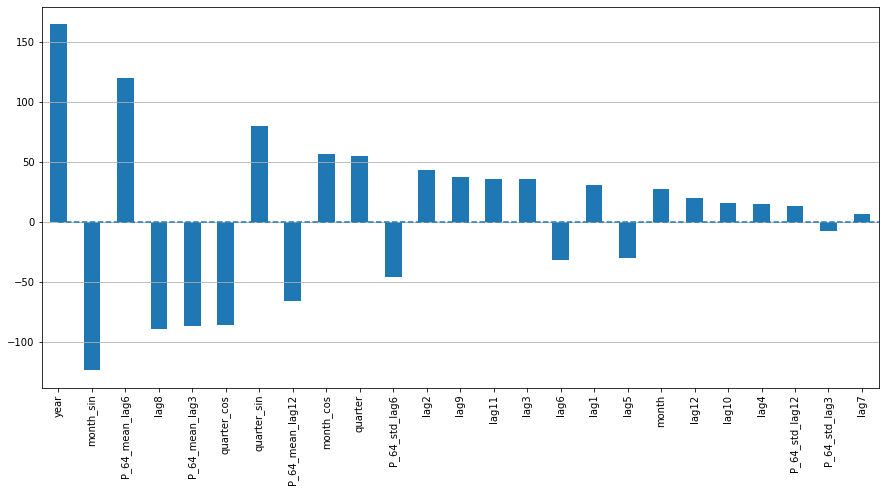

In [28]:
plotModelResults([["Linear Regression", lr]], 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled,
                 y_train=y_train,
                 y_test=y_test,
                 plot_intervals=True)
plotCoefficients(lr)

In [29]:
from sklearn.linear_model import LassoCV, RidgeCV

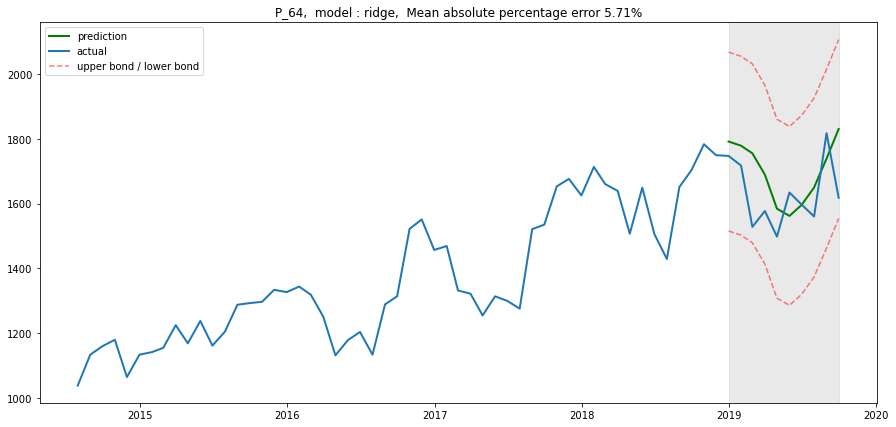

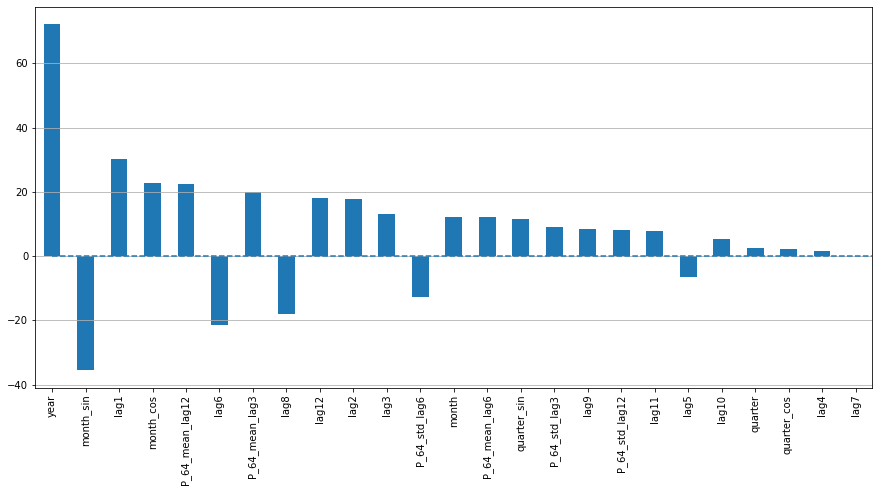

In [30]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults([["ridge", ridge]], 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled,
                 y_train=y_train,
                 y_test=y_test,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

La figure ci-dessous représente les prévisions pour chaque produit par le modèle qui minimise l'erreur (MAPE) parmis les deux modèles de régularisation.

IL RESTE LE DIAGNOSTIC DU RESIDU ET LE CALCUL DES AUTRES METRIQUES

In [31]:
def auto_features_forecast(series, models, test_size=0.15):
    fig, axs = plt.subplots(5, 2, figsize=(20, 20))
    axs = axs.flatten()
    month_in_year = 12
    month_quarter =4
    for i, col in enumerate(series.columns):
        df = series[[col]]
        for j in range(1, 13):
            df[f"lag{j}"] = df[col].shift(j)

        df['year'] = df.index.year
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter

        df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
        df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

        df['quarter_sin'] = np.sin(2*np.pi*df['quarter']/month_quarter)
        df['quarter_cos'] = np.cos(2*np.pi*df['quarter']/month_quarter)

        df["Date"] = df.index
        df.reset_index(drop=True, inplace=True)
        window1 = 3
        window2 = 6
        window3 = 12

        df_rolled_3d = df[[col]].rolling(window=window1, min_periods=0)
        df_rolled_7d = df[[col]].rolling(window=window2, min_periods=0)
        df_rolled_30d = df[[col]].rolling(window=window3, min_periods=0)

        df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
        df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
        df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

        df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
        df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
        df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

        df[f"{col}_mean_lag{window1}"] = df_mean_3d[col]
        df[f"{col}_mean_lag{window2}"] = df_mean_7d[col]
        df[f"{col}_mean_lag{window3}"] = df_mean_30d[col]

        df[f"{col}_std_lag{window1}"] = df_std_3d[col]
        df[f"{col}_std_lag{window2}"] = df_std_7d[col]
        df[f"{col}_std_lag{window3}"] = df_std_30d[col]

        df.fillna(df.mean(), inplace=True)

        df.set_index("Date", drop=False, inplace=True)

        y = df.dropna()[col]
        X = df.dropna().drop([col, 'Date'], axis=1)

        # reserve 20% of data for testing
        X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for _, model in models :
            model.fit(X_train_scaled, y_train)

        plotModelResults(models, 
                         X_train=X_train_scaled, 
                         X_test=X_test_scaled, 
                         y_train=y_train,
                         y_test=y_test,
                         plot_intervals=True, plot_anomalies=True, axe = axs[i])

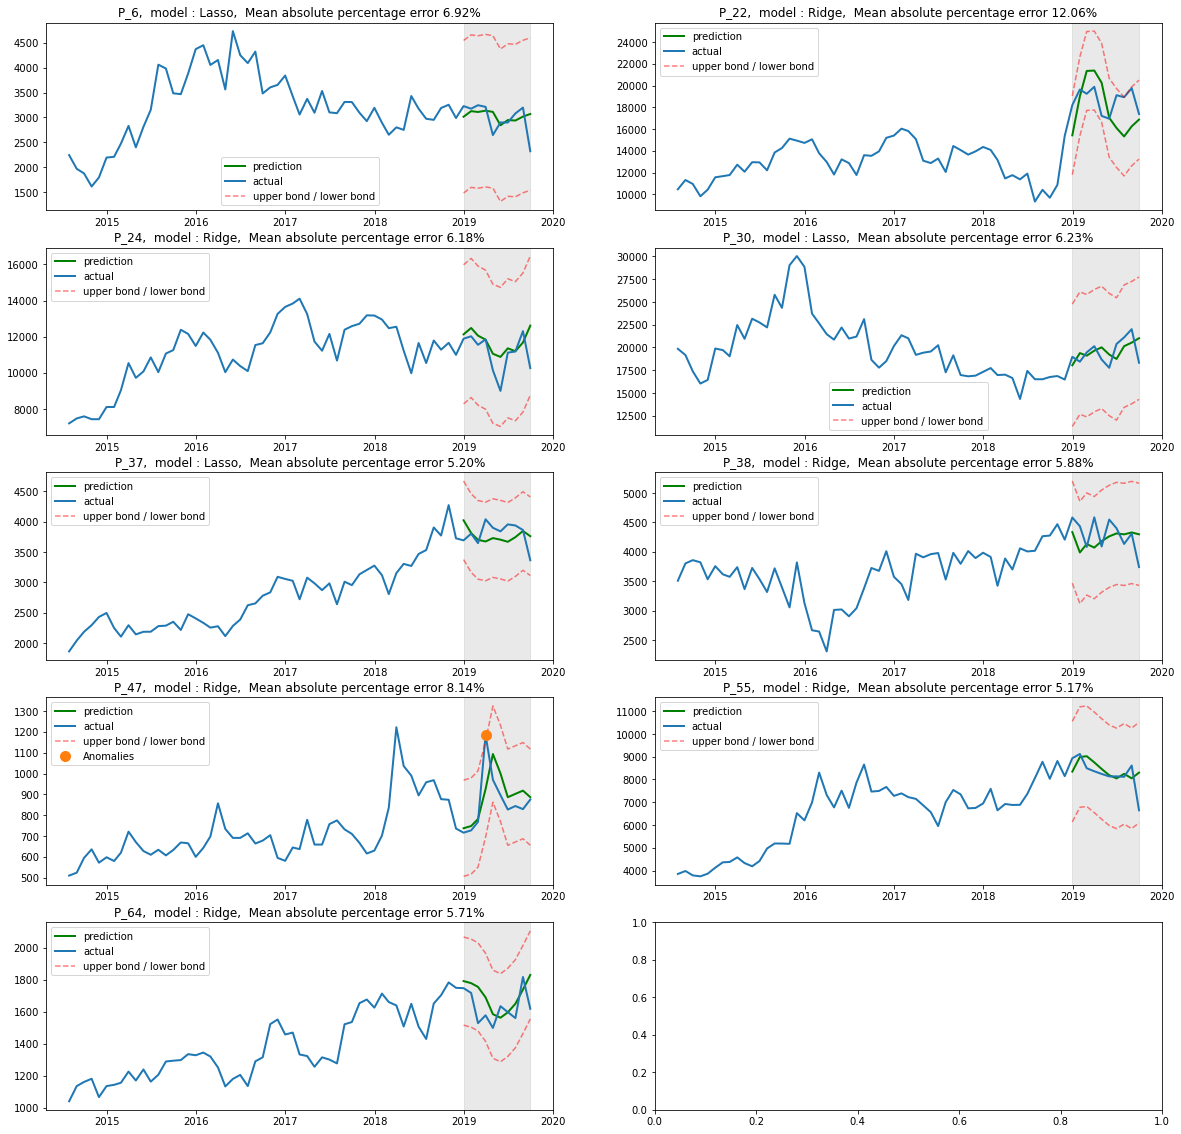

In [32]:
ridge = RidgeCV(cv=tscv)
lasso = LassoCV(cv=tscv)
auto_features_forecast(sales_s, [["Lasso", lasso], ["Ridge", ridge]])

In [33]:
from xgboost import XGBRegressor, plot_importance, plot_tree

In [34]:
reg = XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

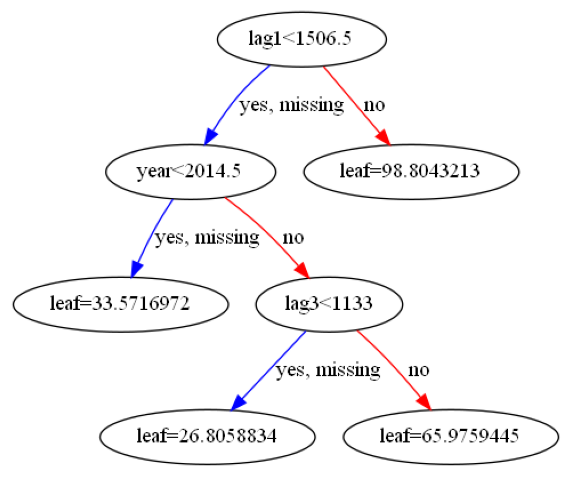

In [36]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(reg, num_trees=5, ax=ax)
plt.show()

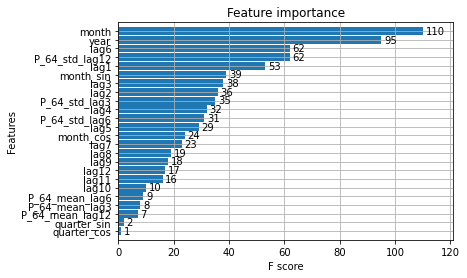

In [37]:
_ = plot_importance(reg, height=0.9)

In [38]:
prediction = reg.predict(X_test)

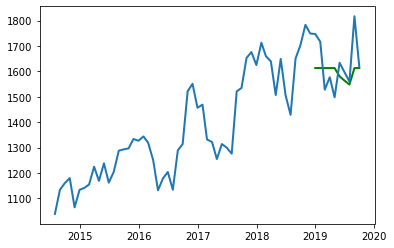

In [39]:
index_of_pred = y_test.index
pred_series = pd.Series(prediction, index=index_of_pred)
plt.plot(pred_series, "g", label="prediction", linewidth=2.0)
plt.plot(pd.concat([y_train, y_test]), label="actual", linewidth=2.0)

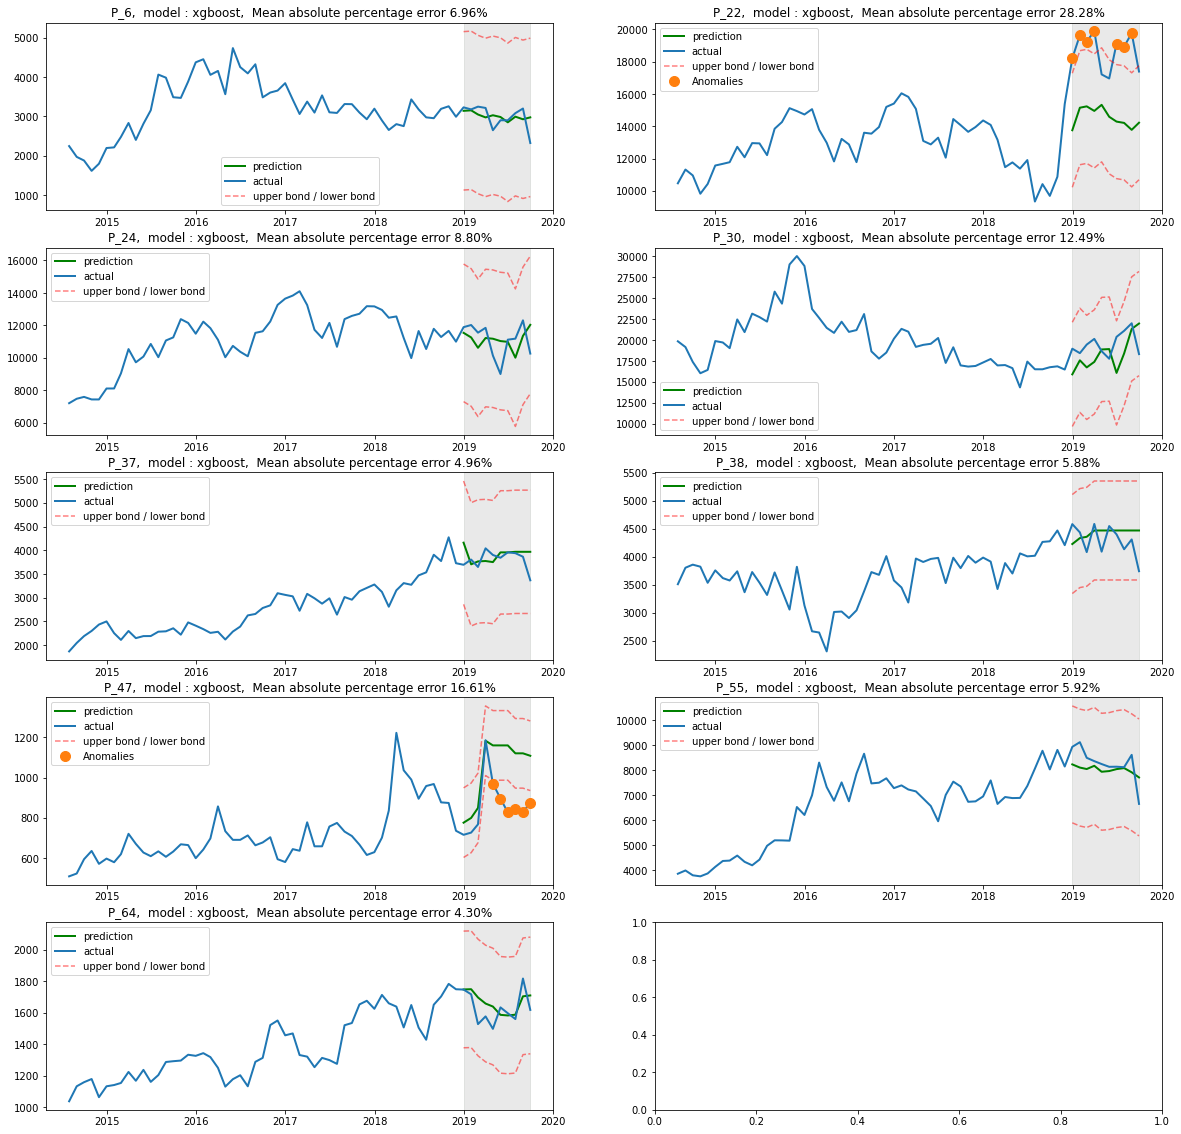

In [40]:
xgb = XGBRegressor()
auto_features_forecast(sales_s, [["xgboost", xgb]])

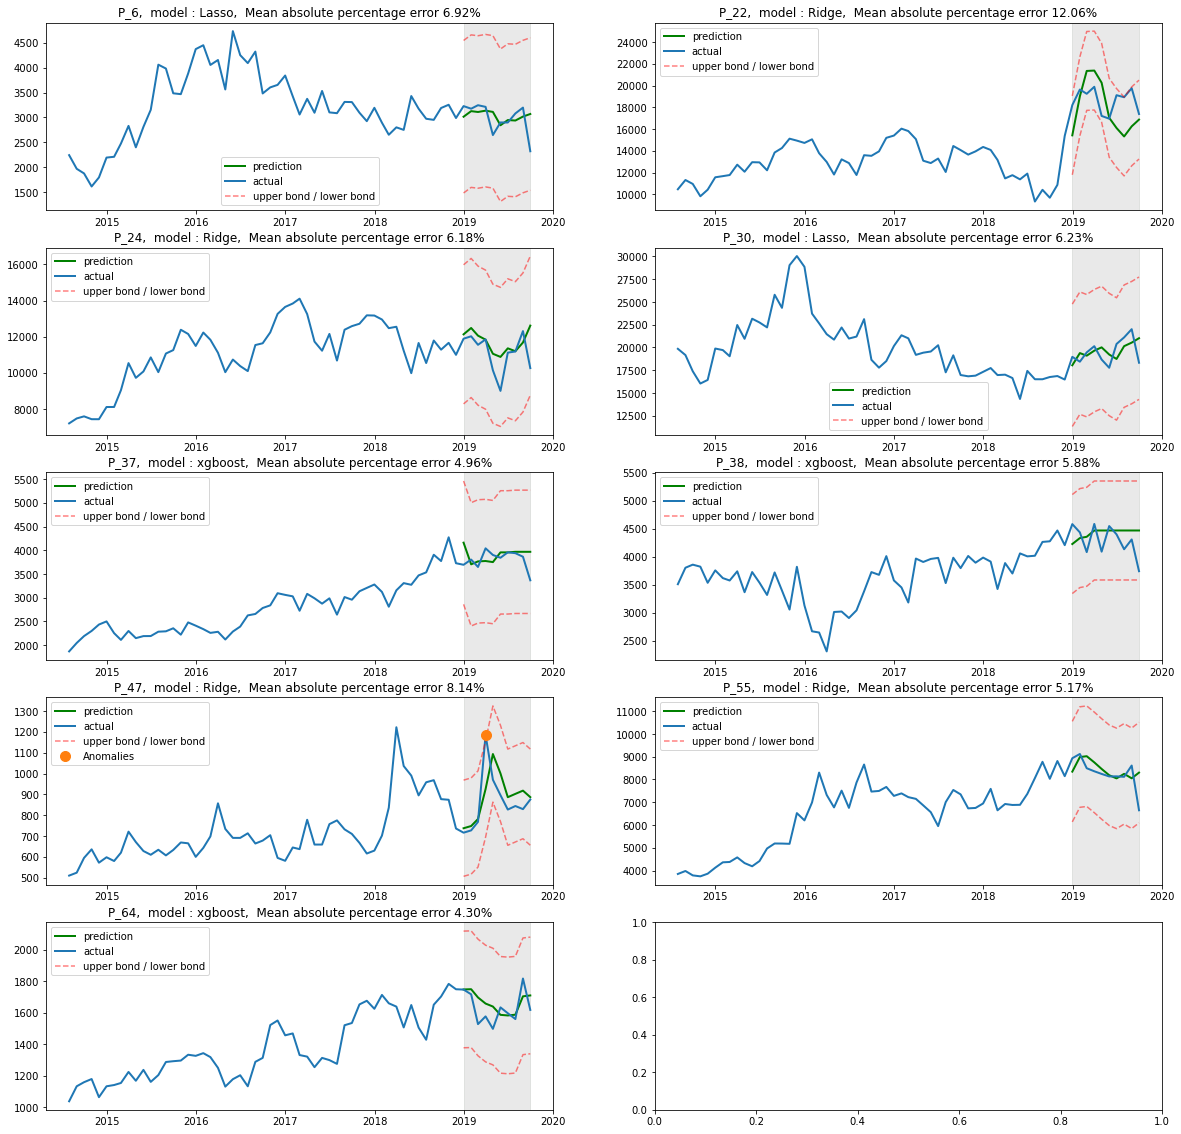

In [43]:
lr = LinearRegression()
ridge = RidgeCV(cv=tscv)
lasso = LassoCV(cv=tscv)
xgb = XGBRegressor()
auto_features_forecast(sales_s, [["LR", lr], ["Lasso", lasso], ["Ridge", ridge], ["xgboost", xgb]])